# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

from pdv import PDV4

# samples
batch_size = 38 # number of samples in each batch
sample_len = 300 # length of each sample
sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = True # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42

# real data parameters
stride = 50 # for real data
start_date = '1995-01-01' # start date for real data
end_date = '2018-09-18' # end date for real data

t = pd.date_range(start=start_date, end=end_date,freq = 'D')
n_timestep = len(t)
df = pd.DataFrame({'Date': t, 'spx': t})
df.set_index('Date', inplace=True)
dt = 1/365

model = PDV4()
prices, log_return, sigma, r10, r11, r20, r21, r1, r2 = model.simulate(1,n_timestep-1)
path = prices[0,:,0].astype(np.float64)
df['spx'] = path
df.to_csv('data/pdv.csv')
df = pd.read_csv('data/pdv.csv', index_col=0, parse_dates=True)
df.info()


# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 10 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = True # feed in history for LSTM generators
hist_len = 50

noise_dim = 4 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 20

epochs = 10000 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.1 # starting kernel_sigma
num_losses = 20


# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)


dataloader = get_dataloader(**{**data_params, **model_params, 'pdv':True})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8662 entries, 1995-01-01 to 2018-09-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     8662 non-null   float64
dtypes: float64(1)
memory usage: 135.3 KB


/Users/hous/Github/Generative-Model-Signature-MMD/utils/gaussianize.py:180: UserWarning: Warning: No convergence after 100 iterations. Increase max_iter.
  warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 7130.894105101806
            Iterations: 45
            Function evaluations: 1052
            Gradient evaluations: 45
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7130.89
Distribution:                  Normal   AIC:                           14303.8
Method:            Maximum Likelihood   BIC:                           14452.2
                                        No. Observations:                 8661
Date:                Tue, Sep 10 2024   Df Residuals:                     8661
Time:                        16:50:33   Df Model:                            0
                               Volatility Model                              


GenLSTM(
  (rnn): LSTM(6, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

# Train MMD-GAN

In [3]:
# train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

In [4]:
base_path = 'runs/Sep06_09-50-55_ada-29_rq_10/'
generator.load_state_dict(torch.load(base_path+'generator.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

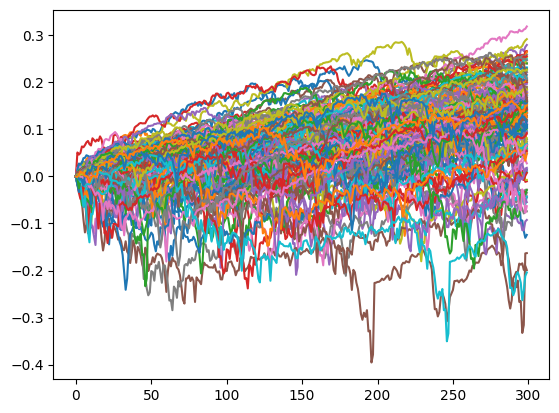

167
torch.Size([38, 300, 2])
torch.Size([38, 299, 4])


In [5]:
# Visualize data
for item in dataloader:
    plt.plot(item[0][:,:,1].T)
plt.show()
print(len(dataloader.dataset))
print(item[0].shape)
print(item[1].shape)

In [26]:

n_noise = 100

hist_x_single = torch.tensor(prices[:,:hist_len,:], dtype=torch.float32)
hist_x = torch.tile(hist_x_single, [n_noise,1,1])

t_single = path[:1,:,:1]
t = torch.tile(t_single, [n_noise,1,1])

self = dataloader.dataset
n_batches = 1


In [27]:
# create MA model with data up to start_date but model parameters will be from self.res.params trained during init
ma_model = arch.arch_model(self.df.loc[:, 'gaussianized'], mean=MEAN_MODEL, p=self.p, q=Q_CONST, rescale=False)

# set distribution of MA model with random state passed in the construction for reproducibility
ma_model.distribution = Normal(seed=self.rs)

# for _ in tqdm(range(n_batches)):
for _ in range(n_batches):
    forecasts = ma_model.forecast(params=self.res.params, horizon=self.sample_len-1, method='simulation', simulations=self.noise_dim*n_noise)
    noise = forecasts.simulations.residuals[0].T
    noise = noise.reshape(noise.shape[0], self.noise_dim, n_noise).transpose(2, 0, 1) # shape (batch_size, sample_len-1, noise_dim)
    noise = torch.tensor(noise, dtype=self.dtype, device=device, requires_grad=False)


    print(noise.shape)
    print(t.shape)
    print(hist_x.shape)

    output_whist = generator(noise, t, hist_x).detach().cpu().squeeze()
    print(output_whist.shape)

torch.Size([100, 299, 4])
torch.Size([100, 300, 1])
torch.Size([100, 50, 1])
torch.Size([100, 300])


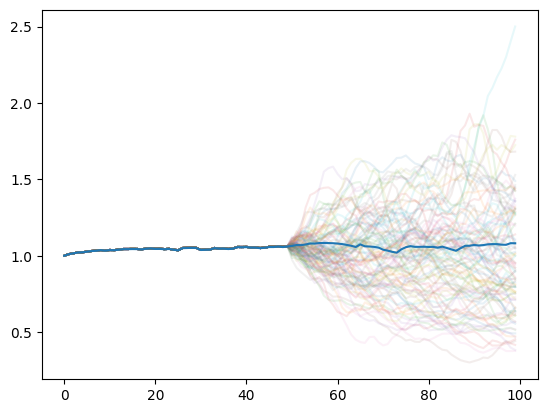

In [31]:
plt.plot(output_whist[:,:100].exp().T, alpha = 0.1);
plt.plot(prices[0,:100,0])

In [9]:
fake_paths = output[:,:,1].exp()

plt.plot(fake_paths[:1000].T);
torch.save(fake_paths,base_path + 'fake_path.pth')

NameError: name 'output' is not defined